# Full VE problem analysis template

In [1]:
import os
import sys
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
#import sympy as sym
import torch

sys.path.append('../src')
import deepymod_torch.VE_datagen as VE_datagen
import deepymod_torch.VE_params as VE_params
from deepymod_torch.DeepMod import DeepMoD
from deepymod_torch.library_function import mech_library

np.random.seed(0)
torch.manual_seed(0)

/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

## Data generation

> The below cell is very important for preparing the generation, examination, and saving of the data. It is one of only a few cells that requires configuration in the notebook.

Specify the functional form of the input

In [2]:
#t = sym.symbols('t', real=True)
#input_expr = sym.sinc(omega*t)

# Wave packets
# omega = 1
# input_expr, d_input_expr, input_torch_lambda = VE_datagen.wave_packet_lambdas_sum(omega, 0.1, 1)

# step
# input_expr = lambda t: 1
# d_input_expr = lambda t: 0
# input_torch_lambda = lambda t: 1 + 0*t

# sine
# omega = 1
# input_expr = lambda t: np.sin(omega*t)
# d_input_expr = lambda t: omega*np.cos(omega*t)
# input_torch_lambda = lambda t: torch.sin(omega*t)

# sinc
omega = 2*np.pi
Amp = 7
input_expr = lambda t: Amp*np.sin(omega*t)/(omega*t)
d_input_expr = lambda t: (Amp/t)*(np.cos(omega*t) - np.sin(omega*t)/(omega*t))
input_torch_lambda = lambda t: Amp*torch.sin(omega*t)/(omega*t)

# sinc with hshift
# omega = 1
# shift = 6*np.pi
# input_expr = lambda t: np.sin(omega*(t - shift))/(omega*(t - shift))
# d_input_expr = lambda t: (1/(t - shift))*(np.cos(omega*(t - shift)) - np.sin(omega*(t - shift))/(omega*(t - shift)))
# input_torch_lambda = lambda t: torch.sin(omega*(t - shift))/(omega*(t - shift))

# sinc with vshift
# omega = np.pi
# neg_edge = -7.5 # for now is 3.75*T where T is 2*pi/omega. The 3.75 is chosen but could be any (n +- 0.25) where n is integer > 0.
# input_expr_no_shift = lambda t: np.sin(omega*t)/(omega*t)
# vshift = input_expr_no_shift(neg_edge)
# input_expr = lambda t: input_expr_no_shift(t) - vshift
# d_input_expr = lambda t: (1/t)*(np.cos(omega*t) - np.sin(omega*t)/(omega*t))
# input_torch_lambda = lambda t: torch.sin(omega*t)/(omega*t) - vshift

# sinc with both hshift and vshift
# omega = np.pi
# hshift = 7.5 # for now is 3.75*T where T is 2*pi/omega. The 3.75 is chosen but could be any (n +- 0.25) where n is integer > 0.
# input_expr_h_only = lambda t: np.sin(omega*(t - hshift))/(omega*(t - hshift))
# vshift = input_expr_h_only(0)
# input_expr = lambda t: input_expr_h_only(t) - vshift
# d_input_expr = lambda t: (1/(t - shift))*(np.cos(omega*(t - shift)) - np.sin(omega*(t - shift))/(omega*(t - shift)))
# input_torch_lambda = lambda t: torch.sin(omega*(t - hshift))/(omega*(t - hshift)) - vshift

input_type = 'Strain'
func_desc = 'half sinc mirroring real data'

### FT limit (sinc only)

theory limit

In [3]:
2/omega

0.3183098861837907

30% of limit which seems to be the actual cut off

In [4]:
0.6/omega

0.0954929658551372

> Return

Specify the model parameters

In [5]:
E = [5e-4, 5e-4, 5e-4]
eta = [2.2e-4, 1e-3] # [2.2e-4, 0.5*5e-4/omega]
#eta = [i*5e-4/omega for i in eta] # get rid

E_alt = np.array(E[1:])
eta_alt = np.array(eta)
tau = eta_alt/E_alt
tau

array([0.44, 2.  ])

Specify the independant data points over which to synthesise the data.

In [6]:
time_array = np.linspace(10**-10, 10*np.pi/omega, 5000).reshape(-1, 1)

In [7]:
strain_array, stress_array = VE_datagen.calculate_strain_stress(input_type, time_array, input_expr, E, eta, D_input_lambda=d_input_expr)

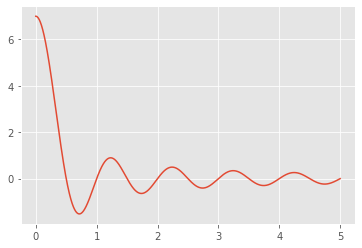

In [8]:
plt.plot(time_array.flatten(), strain_array.flatten(), label='strain')

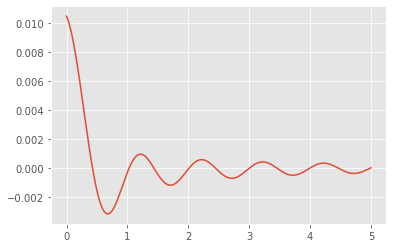

In [9]:
plt.plot(time_array.flatten(), stress_array.flatten(), label='stress')

## Generation Validation

In [10]:
errors = VE_datagen.equation_residuals(time_array, strain_array, stress_array, E, eta, input_type)

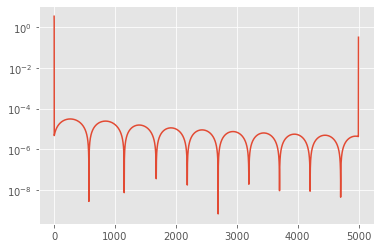

In [11]:
plt.semilogy(abs(errors.flatten()))

## Data Treatment

Presence of t/time_sf in new lambdas is hard to understand but has a reason. The reason is that while unscaled t, stress and strain all map to each other, they need to all map once scaled also. Scaling the time array does not change the target array as these are both precalculated. however, because the analytical input data is calculated based off this NEW SCALED time series in the library function, it is calculated over the scaled time series for the old function, effectively doubling the number of bumps in the curve, rather than stretching it out. we want to calculate the old input_data, ie that originates from the unscaled time data, so we have to unscale the time data on the fly in the library, hence the factor in the lambda function.

This allows PyTorch to map scaled time to scaled input and calculate the appropriate derivatives

Note, this is not an issue for the real data as there is no analytical input term, and the input variable is a dumb target, just like the output variable.

In [12]:
# 'normalising'
# time_sf = omega # we want T of effective curve to be 2pi. Teff = T*t_sf = 2pi*t_sf/omega = 2pi if t_sf = omega
# T_want = 5
# time_sf = T_want * (omega/(2*np.pi)) # Alternatively, if we don't want 2pi, get whatever wanted by sf = T_want * (omega/2pi)
time_sf = omega/1.17
strain_sf = 1/np.max(abs(strain_array))
stress_sf = 1/np.max(abs(stress_array))
print(time_sf, strain_sf, stress_sf)

scaled_time_array = time_array*time_sf
if input_type == 'Strain':
    scaled_input_torch_lambda = lambda t: strain_sf*input_torch_lambda(t/time_sf)
    scaled_target_array = stress_array*stress_sf
elif input_type == 'Stress':
    scaled_input_torch_lambda = lambda t: stress_sf*input_torch_lambda(t/time_sf)
    scaled_target_array = strain_array*strain_sf

5.370243852290245 0.14285714285714285 95.23809523809523


In [13]:
# add noise
noise_level = 0

noisy_target_array = scaled_target_array + noise_level * np.std(scaled_target_array) * np.random.standard_normal(scaled_target_array.shape)

In [14]:
# sampling
number_of_samples = 1000

reordered_row_indices = np.random.permutation(time_array.size)

reduced_time_array = scaled_time_array[reordered_row_indices, :][:number_of_samples]
reduced_target_array = noisy_target_array[reordered_row_indices, :][:number_of_samples]

# The below code is a slight alternative version that produces data and targets that are still in chronological order.
# selected_row_indices = reordered_row_indices[:number_of_samples]
# selected_row_indices.sort()
# reduced_time_array = scaled_time_array[selected_row_indices, :]
# reduced_target_array = noisy_target_array[selected_row_indices, :]

## DeepMod prep

In [15]:
time_tensor = torch.tensor(reduced_time_array, dtype=torch.float32, requires_grad=True)
target_tensor = torch.tensor(reduced_target_array, dtype=torch.float32)

In [16]:
optim_config = {'lambda': 0, 'lr_coeffs': 0.005, 'max_iterations': 100001, 'mse_only_iterations': 20001, 'final_run_iterations': 10001}

In [17]:
network_config = {'input_dim': 1, 'hidden_dim': 30, 'layers': 4, 'output_dim': 1}

In [18]:
library_config = {'type': mech_library, 'diff_order': 2, 'coeff_sign': 'positive', 'input_type': input_type, 'input_expr': scaled_input_torch_lambda}

## Predicting Coefficients

Predict the true values of the coefficients, based only on the viscoelastic model. These are not necessarily the constants that DeepMoD will find as DeepMoD will only see the scaled data.

In [19]:
if input_type == 'Stress':
    not_floats = VE_params.coeffs_from_model_params_kelvin(E, eta)
elif input_type == 'Strain':
    not_floats = VE_params.coeffs_from_model_params_maxwell(E, eta)
        
[float(x) for x in not_floats]

[0.20491803278688525,
 0.5409836065573771,
 409.83606557377044,
 999.9999999999999,
 360.655737704918]

Scale the true coeffs to what deepmod should find based on the scaling of each term in the equation.

In [20]:
expected_coeffs = VE_params.scaled_coeffs_from_true(not_floats, time_sf, strain_sf, stress_sf)
expected_coeffs

[0.0381580498806388,
 2.90521388730456,
 0.114474149641917,
 1.50000000000000,
 2.90521388730456]

## Running DeepMoD

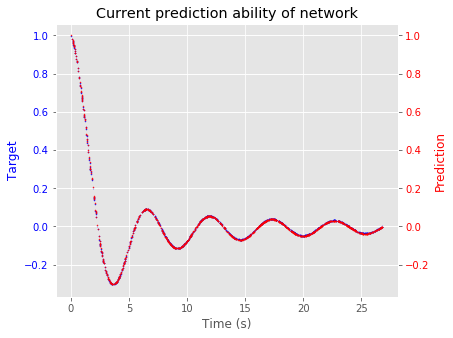

Epoch | Total loss | MSE | PI | L1 
10000 4.9E-06 2.7E-06 2.2E-06 0.0E+00
tensor([[0.0893],
        [0.4441],
        [0.2204],
        [1.0778],
        [0.4130]], requires_grad=True)
Time elapsed: 7.0 minutes 14.70357370376587 seconds


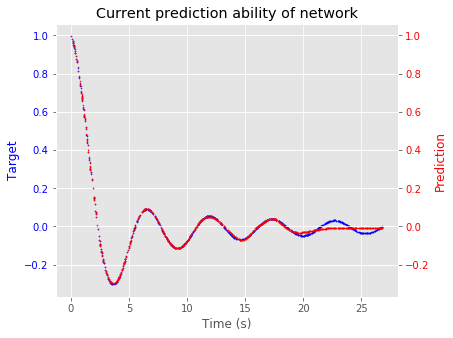

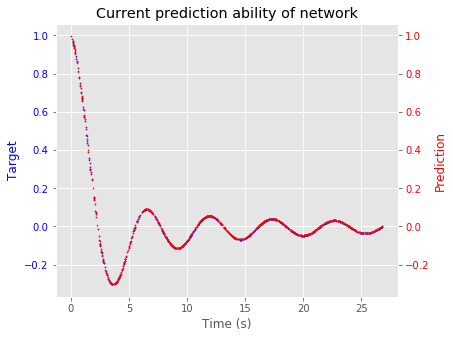

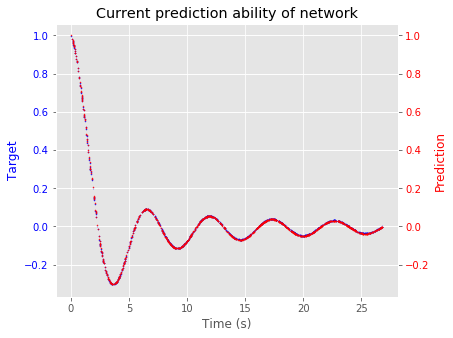

In [21]:
begin_timestamp = datetime.now()
sparse_coeff_vector_list_list, scaled_coeff_vector_list_list, sparsity_mask_list_list, network = DeepMoD(time_tensor, target_tensor, network_config, library_config, optim_config, print_interval=500, plot=True)

### Results

In [22]:
sparse_coeff_vector_list_list

[[tensor([[0.0894],
          [0.4136],
          [0.2224],
          [1.0735],
          [0.3832]], requires_grad=True)], [tensor([[0.0895],
          [0.4440],
          [0.2202],
          [1.0779],
          [0.4131]], requires_grad=True)]]

In [23]:
scaled_coeff_vector_list_list

[[tensor([[0.1379],
          [0.3800],
          [0.3140],
          [1.1504],
          [0.3209]], grad_fn=<MulBackward0>)], [tensor([[0.1380],
          [0.4079],
          [0.3117],
          [1.1557],
          [0.3468]], grad_fn=<MulBackward0>)]]

In [24]:
sparsity_mask_list_list

[[tensor([0, 1, 2, 3, 4])], [tensor([0, 1, 2, 3, 4])]]

## Results Processing

> Run as far as here in one shot, then check that the below two code cells are correct, in particular, the string, `success_state` cannot be preset.

In [29]:
success_state = 'Fail'

In [30]:
investigated_param = 'Trying to get 2nd order problem working again'
param_value = 'NA'
repeat_instance = 0

> From here, you can run the rest of the code.

In [31]:
prediction_array = np.array(network(time_tensor).detach())

if `prediction_coeffs_array` is not equal dimensionally to the `target_coeffs_array`, there would be an error if it weren't for the `if` statement prempting this. In the case where the dimensions don't agree, there is no sensible way to assess these quantities anyway, so this data is mostly abandoned. The coeffs before thresholding are however saved as `pre_thresh_coeffs_array`.

In [32]:
target_coeffs_array = np.array(expected_coeffs).reshape(-1,1)

pre_thresh_coeffs_array = np.array(sparse_coeff_vector_list_list[0][0].detach())
pre_thresh_scaled_coeffs_array = np.array(scaled_coeff_vector_list_list[0][0].detach())

final_coeffs_array = np.array(sparse_coeff_vector_list_list[-1][0].detach())
final_scaled_coeffs_array = np.array(scaled_coeff_vector_list_list[-1][0].detach())
sparsity_mask_array = np.array(sparsity_mask_list_list[-1][0]).reshape(-1,1)

if statement just bypasses errors

In [33]:
dg_series_data = np.concatenate((time_array, strain_array, stress_array), axis=1)
NN_series_data = np.concatenate((reduced_time_array, reduced_target_array, prediction_array), axis=1)
pre_thresh_coeffs_data = np.concatenate((pre_thresh_coeffs_array, pre_thresh_scaled_coeffs_array), axis=1)
final_coeffs_data = np.concatenate((final_coeffs_array, final_scaled_coeffs_array, sparsity_mask_array), axis=1)

In [34]:
dt_string = begin_timestamp.strftime('%d/%m/%Y %H:%M:%S')

In [39]:
input_theta = library_config.pop('input_theta')

In [40]:
dg_info_list = ['E: '+str(E), 'eta: '+str(eta), 'Input: '+input_type, 'Desc: '+func_desc, 'omega: '+str(omega), 'Amp: '+str(Amp)]
dg_info_list

['E: [0.0005, 0.0005]',
 'eta: [0.0025]',
 'Input: Strain',
 'Desc: half sinc mirroring real data',
 'omega: 0.1',
 'Amp: 7']

In [41]:
treatment_info_list = ['noise_factor: '+str(noise_level), 'time_sf: '+str(time_sf), 'strain_sf: '+str(strain_sf), 'stress_sf: '+str(stress_sf)]
treatment_info_list

['noise_factor: 0', 'time_sf: 0.1', 'strain_sf: 0.1', 'stress_sf: 100']

In [42]:
config_dict_list = ['optim: '+str(optim_config), 'network: '+str(network_config), 'library: '+str(library_config)]
config_dict_list

["optim: {'lambda': 1e-05, 'lr_coeffs': 0.002, 'max_iterations': 100001, 'mse_only_iterations': 20001, 'final_run_iterations': 10001}",
 "network: {'input_dim': 1, 'hidden_dim': 30, 'layers': 4, 'output_dim': 1}",
 "library: {'type': <function strain_input_library at 0x7fe2436c06a8>, 'diff_order': 2, 'coeff_sign': 'positive', 'input_type': 'Strain', 'input_expr': <function <lambda> at 0x7fe240a78e18>}"]

In [43]:
misc_list = ['date_stamp: '+dt_string, 'success: '+success_state]
misc_list

['date_stamp: 16/03/2020 13:42:09', 'success: Fail']

## Saving

In [44]:
parent_folder = '../data/Results'
first_subfolder = investigated_param.replace('.', '-')
second_subfolder = 'param_' + str(param_value).replace('.', '-')
third_subfolder = 'repeat_' + str(repeat_instance)

foldername = parent_folder + '/' + first_subfolder + '/' + second_subfolder + '/' + third_subfolder

In [45]:
if not os.path.isdir(foldername):
    os.makedirs(foldername)

In [46]:
np.savetxt(foldername+'/DG_series_data.csv', dg_series_data, delimiter=',', header='Time, Strain, Stress')
np.savetxt(foldername+'/NN_series_data.csv', NN_series_data, delimiter=',', header='Time, Target, Prediction')
np.savetxt(foldername+'/expected_coeffs.csv', target_coeffs_array, delimiter=',', header='Expected_coeffs')
np.savetxt(foldername+'/pre_thresh_coeffs_data.csv', pre_thresh_coeffs_data, delimiter=',', header='Trained_Coeffs, Scaled_Trained_Coeffs')
np.savetxt(foldername+'/final_coeffs_data.csv', final_coeffs_data, delimiter=',', header='Trained_Coeffs, Scaled_Trained_Coeffs, Sparsity_Mask')

In [47]:
with open(foldername+'/DG_info_list.txt', 'w') as file:
    file.writelines("%s\n" % line for line in dg_info_list)

In [48]:
with open(foldername+'/treatment_info_list.txt', 'w') as file:
    file.writelines("%s\n" % line for line in treatment_info_list)

In [49]:
with open(foldername+'/config_dict_list.txt', 'w') as file:
    file.writelines("%s\n" % line for line in config_dict_list)

In [50]:
with open(foldername+'/misc_list.txt', 'w') as file:
    file.writelines("%s\n" % line for line in misc_list)